# IMDB Movie Review classification
* Author: Johannes Maucher
* Last Update: 16.07.2024

## Text-Classification in general
Until this stage of the lecture you should be aware of the following 4 different approaches for text classification:

1. **Bag-of-Word + Conventional ML**: This is a quite old approach for text classifications. Texts are modelled as *Bag-of-Word* vectors and these numeric vectors can be passed to any conventional ML algorithm e.g. Naive Bayes, Logistic Regresseion, SVM, SLP, MLP, ...

2. **Embedding-Bag + Conventional ML**: 

```{figure} https://maucher.home.hdm-stuttgart.de/Pics/textBagLinear.png
---
align: center
width: 600pt
name:  embeddingbag
---
Embedding-Bag: For each word in the text a word embedding is calculated and all embeddings are added. The resulting summed vector is passed to any conventional ML algorithm.
```

3. **Word Embeddings passed to a 1D-CNNL**: 

```{figure} https://maucher.home.hdm-stuttgart.de/Pics/text1DConv.png
---
align: center
width: 500pt
name:  embedding1dcnn
---
Embeddings of the words in the text are passed in order to the input of a 1-D CNN.
```

4. **Word Embeddings passed to a RNN (any type of RNN)**: 
```{figure} https://maucher.home.hdm-stuttgart.de/Pics/textRNN.png
---
align: center
width: 550pt
name:  embeddingrnn
---
Embeddings of the words in the text are passed in order to the input of a RNN of any type.
```

In this notebook we implement approach 3 and 4 for classifying IMDB movie reviews. Later on you will also learn how a Transformer like BERT can be applied for text-classification.


## Access IMDB dataset
The IMDB Movie Review corpus is a standard dataset for the evaluation of text-classifiers. It consists of 25000 movies reviews from IMDB, labeled by sentiment (positive/negative). In this notebook a Convolutional Neural Network (CNN) is implemented for sentiment classification of IMDB reviews.

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, Dense, Input, Flatten, Conv1D, MaxPooling1D, Dropout, Concatenate, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import imdb

2024-12-09 20:41:04.905965: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-09 20:41:04.906111: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 20:41:05.173575: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 20:41:05.744627: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-09 20:41:09.347972: W tensorflow/compiler/tf2

In [2]:
MAX_NB_WORDS = 10000        # number of most-frequent words that are regarded, all others are ignored
EMBEDDING_DIM = 100         # dimension of word-embedding
INDEX_FROM=3

The [IMDB dataset](https://keras.io/datasets/) is already available in Keras and can easily be accessed by

`imdb.load_data()`. 

The returned dataset contains the sequence of word indices for each review. 

In [46]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=MAX_NB_WORDS,index_from=INDEX_FROM)

In [47]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(25000,)
(25000,)
(25000,)
(25000,)


First 15 tokens of the first training document:

In [48]:
X_train[0][:15] #plot first 10 elements of the sequence

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4]

First 15 tokens of the second training document:

In [49]:
X_train[1][:15] #plot first 10 elements of the sequence

[1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 4369, 5012, 134, 26, 4]

First 15 tokens of the third training document:

In [50]:
X_train[2][:15] #plot first 10 elements of the sequence

[1, 14, 47, 8, 30, 31, 7, 4, 249, 108, 7, 4, 5974, 54, 61]

The representation of text as sequence of integers is good for Machine Learning algorithms, but useless for human text understanding. Therefore, we also access the word-index from [Keras IMDB dataset](https://keras.io/api/datasets/imdb/), which maps words to the associated integer-IDs. Since we like to map integer-IDs to words we calculate the inverse wordindex `inv_wordindex`: 

In [51]:
wordindex=imdb.get_word_index(path="imdb_word_index.json")

**Example:** Index of word `the`:

In [52]:
wordindex["the"]

1

As can be seen, in the output above the index of word `the` is 1. This is because the index is ordered w.r.t. the frequency of words in the dictionary and `the` is the most frequent word.

However, the wordindex which we got from `imdb.get_word_index()` is not exactly the index, which has been applied in the indexing of imdb-reviews, which are returned by the method `imdb.load_data()`. The difference is a shift of 3 in the indexes. I.e. in the reviews, returned by `imdb.load_data()` the word `the` is represented by the integer 4. This is because in the vocabulary applied for `imdb.load_data()` four special tokens are added at the first index-positions. We also have to add this special tokens, if we like to decode our integer-sequences to real texts: 

In [53]:
wordindex = {k:(v+INDEX_FROM) for k,v in wordindex.items()}
wordindex["<PAD>"] = 0
wordindex["<START>"] = 1
wordindex["<UNK>"] = 2
wordindex["<UNUSED>"] = 3

Now the index of word `the` is:

In [54]:
wordindex["the"]

4

Next, we calculate the inverse wordindex, which maps integers to words:

In [55]:
inv_wordindex = {value:key for key,value in wordindex.items()}

Now, we can decode the integer-sequences of our reviews into real texts. The first film-review of the training-partition then reads as follows:

In [56]:
print(' '.join(inv_wordindex[id] for id in X_train[1] ))

<START> big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal <UNK> the hair is big lots of boobs <UNK> men wear those cut <UNK> shirts that show off their <UNK> sickening that men actually wore them and the music is just <UNK> trash that plays over and over again in almost every scene there is trashy music boobs and <UNK> taking away bodies and the gym still doesn't close for <UNK> all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then


Next the distribution of review-lengths (words per review) is calculated:

In [57]:
textlenghtsTrain=[len(t) for t in X_train]

In [58]:
from matplotlib import pyplot as plt

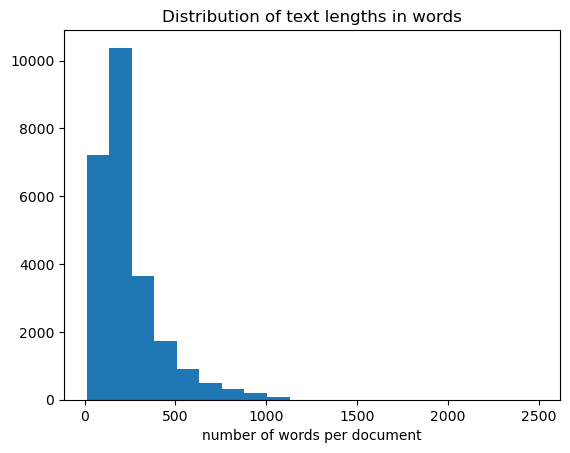

In [59]:
plt.hist(textlenghtsTrain,bins=20)
plt.title("Distribution of text lengths in words")
plt.xlabel("number of words per document")
plt.show()

Given this length-distribution, we set our sequence length as follows:

In [60]:
MAX_SEQUENCE_LENGTH = 500  # all text-sequences are padded to this length

## Preparing Text Sequences and Labels
All sequences must be padded to unique length of `MAX_SEQUENCE_LENGTH`. This means, that longer sequences are cut and shorter sequences are filled with zeros. For this Keras provides the `pad_sequences()`-function. 

In [61]:
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)

In [62]:
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

Moreover, all class-labels must be represented in one-hot-encoded form:

In [63]:
y_train = to_categorical(np.asarray(y_train))
y_test = to_categorical(np.asarray(y_test))
print('Shape of Training Data Input:', X_train.shape)
print('Shape of Training Data Labels:', y_train.shape)

Shape of Training Data Input: (25000, 500)
Shape of Training Data Labels: (25000, 2)


In [64]:
print('Number of positive and negative reviews in training and validation set ')
print (y_train.sum(axis=0))
print (y_test.sum(axis=0))

Number of positive and negative reviews in training and validation set 
[12500. 12500.]
[12500. 12500.]


## CNN with 2 Convolutional Layers

The first network architecture consists of
* an embedding layer. This layer takes sequences of integers and learns word-embeddings. The sequences of word-embeddings are then passed to the first convolutional layer
* two 1D-convolutional layers with different number of filters and different filter-sizes
* two Max-Pooling layers to reduce the number of neurons, required in the following layers
* a MLP classifier with one hidden layer and the output layer

### Prepare Embedding Matrix and -Layer 

In [65]:
embedding_layer = Embedding(MAX_NB_WORDS,
                            EMBEDDING_DIM,
                            #weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

### Define CNN architecture

In [66]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(32, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(2)(l_cov1)
l_cov2 = Conv1D(64, 3, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_flat = Flatten()(l_pool2)
l_dense = Dense(64, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)
model = Model(sequence_input, preds)

2024-12-09 21:10:01.898705: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Train Network

In [67]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['categorical_accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 100)          1000000   
                                                                 
 conv1d (Conv1D)             (None, 496, 32)           16032     
                                                                 
 max_pooling1d (MaxPooling1  (None, 248, 32)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 246, 64)           6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 49, 64)            0         
 g1D)                                                        

In [68]:
print("model fitting - simplified convolutional neural network")
history=model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=6, verbose=False, batch_size=128)

model fitting - simplified convolutional neural network


In [69]:
%matplotlib inline
from matplotlib import pyplot as plt

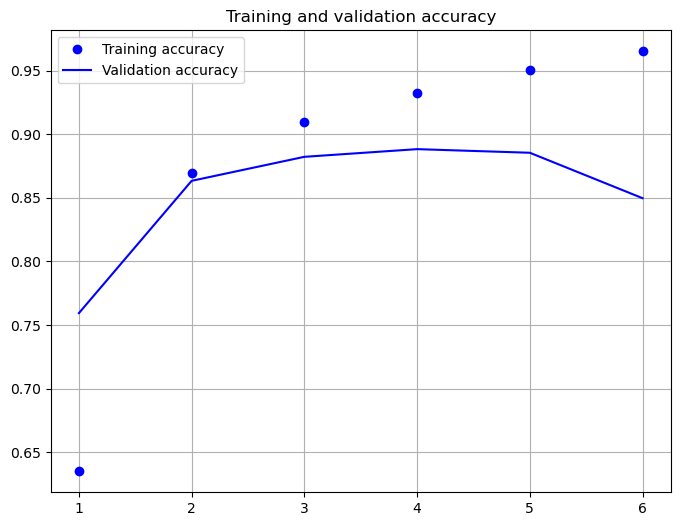

In [70]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
max_val_acc=np.max(val_acc)

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8,6))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [71]:
model.evaluate(X_test,y_test)

782/782 [==============================] - 5s 7ms/step - loss: 0.5011 - categorical_accuracy: 0.8498


[0.5010811686515808, 0.8497599959373474]

As shown above, after 6 epochs of training the cross-entropy-loss is 0.501 and the accuracy is 84.98%. However, it seems that the accuracy-value after 3 epochs has been higher, than the accuracy after 6 epochs. This indicates overfitting due to too long learning.

## CNN with different filter sizes in one layer
In [Y. Kim; Convolutional Neural Networks for Sentence Classification](https://arxiv.org/pdf/1408.5882v2.pdf) a CNN with different filter-sizes in one layer has been proposed. This CNN is implemented below:

![KimCnn](https://maucher.home.hdm-stuttgart.de/Pics/KimCnn.png)

Source: [Y. Kim; Convolutional Neural Networks for Sentence Classification](https://arxiv.org/pdf/1408.5882v2.pdf)

### Prepare Embedding Matrix and -Layer

In [72]:
embedding_layer = Embedding(MAX_NB_WORDS,
                            EMBEDDING_DIM,
                            #weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

### Define Architecture

In [73]:
convs = []
filter_sizes = [3,4,5]

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

for fsz in filter_sizes:
    l_conv = Conv1D(filters=32,kernel_size=fsz,activation='relu')(embedded_sequences)
    l_pool = MaxPooling1D(4)(l_conv)
    convs.append(l_pool)
    
l_merge = Concatenate(axis=1)(convs)
l_cov1= Conv1D(64, 5, activation='relu')(l_merge)
l_pool1 = GlobalMaxPool1D()(l_cov1)
#l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
#l_pool2 = MaxPooling1D(30)(l_cov2)
l_flat = Flatten()(l_pool1)
l_dense = Dense(64, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)

model = Model(sequence_input, preds)

In [74]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 500)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 500, 100)             1000000   ['input_2[0][0]']             
                                                                                                  
 conv1d_2 (Conv1D)           (None, 498, 32)              9632      ['embedding_1[0][0]']         
                                                                                                  
 conv1d_3 (Conv1D)           (None, 497, 32)              12832     ['embedding_1[0][0]']         
                                                                                            

### Train Network

In [75]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['categorical_accuracy'])

In [76]:
print("model fitting - more complex convolutional neural network")
history=model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=8, batch_size=128)

model fitting - more complex convolutional neural network
Epoch 1/8
196/196 [==============================] - 55s 280ms/step - loss: 0.6112 - categorical_accuracy: 0.6336 - val_loss: 0.3946 - val_categorical_accuracy: 0.8298
Epoch 2/8
196/196 [==============================] - 55s 279ms/step - loss: 0.3409 - categorical_accuracy: 0.8531 - val_loss: 0.3042 - val_categorical_accuracy: 0.8718
Epoch 3/8
196/196 [==============================] - 54s 278ms/step - loss: 0.2382 - categorical_accuracy: 0.9030 - val_loss: 0.2883 - val_categorical_accuracy: 0.8818
Epoch 4/8
196/196 [==============================] - 54s 278ms/step - loss: 0.1749 - categorical_accuracy: 0.9341 - val_loss: 0.2858 - val_categorical_accuracy: 0.8885
Epoch 5/8
196/196 [==============================] - 55s 280ms/step - loss: 0.1228 - categorical_accuracy: 0.9556 - val_loss: 0.2974 - val_categorical_accuracy: 0.8880
Epoch 6/8
196/196 [==============================] - 54s 278ms/step - loss: 0.0839 - categorical_accur

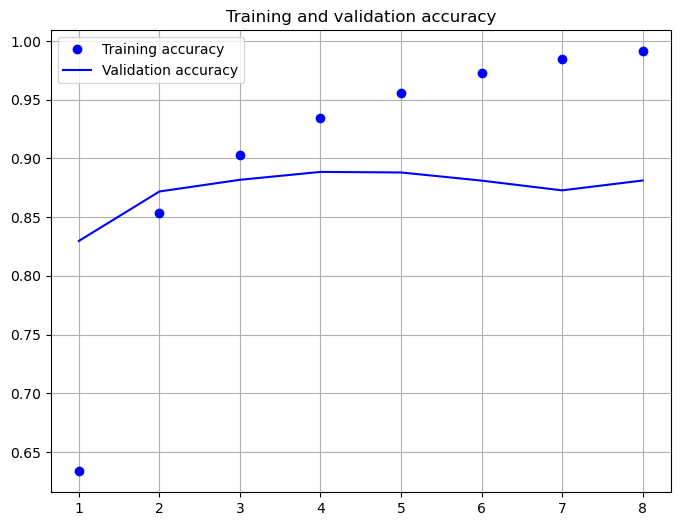

In [77]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
max_val_acc=np.max(val_acc)

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8,6))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [78]:
model.evaluate(X_test,y_test)

782/782 [==============================] - 11s 13ms/step - loss: 0.4342 - categorical_accuracy: 0.8812


[0.4342169463634491, 0.8812000155448914]

As shown above, after 8 epochs of training the cross-entropy-loss is 0.434 and the accuracy is 88.12%.

## LSTM

In [79]:
from tensorflow.keras.layers import LSTM, Bidirectional

In [80]:
embedding_layer = Embedding(MAX_NB_WORDS,
                            EMBEDDING_DIM,
                            #weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [81]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(64))(embedded_sequences)
preds = Dense(2, activation='softmax')(l_lstm)
model = Model(sequence_input, preds)

In [82]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 500, 100)          1000000   
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 dense_4 (Dense)             (None, 2)                 258       
                                                                 
Total params: 1084738 (4.14 MB)
Trainable params: 1084738 (4.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [83]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['categorical_accuracy'])

print("model fitting - Bidirectional LSTM")

model fitting - Bidirectional LSTM


In [84]:
history=model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=6, batch_size=128)

Epoch 1/6
196/196 [==============================] - 150s 754ms/step - loss: 0.5227 - categorical_accuracy: 0.7223 - val_loss: 0.4264 - val_categorical_accuracy: 0.8202
Epoch 2/6
196/196 [==============================] - 147s 752ms/step - loss: 0.3275 - categorical_accuracy: 0.8640 - val_loss: 0.3937 - val_categorical_accuracy: 0.8202
Epoch 3/6
196/196 [==============================] - 147s 748ms/step - loss: 0.2750 - categorical_accuracy: 0.8924 - val_loss: 0.3298 - val_categorical_accuracy: 0.8605
Epoch 4/6
196/196 [==============================] - 147s 752ms/step - loss: 0.2407 - categorical_accuracy: 0.9097 - val_loss: 0.2941 - val_categorical_accuracy: 0.8808
Epoch 5/6
196/196 [==============================] - 147s 751ms/step - loss: 0.2142 - categorical_accuracy: 0.9184 - val_loss: 0.4389 - val_categorical_accuracy: 0.8352
Epoch 6/6
196/196 [==============================] - 147s 750ms/step - loss: 0.1928 - categorical_accuracy: 0.9289 - val_loss: 0.4811 - val_categorical_acc

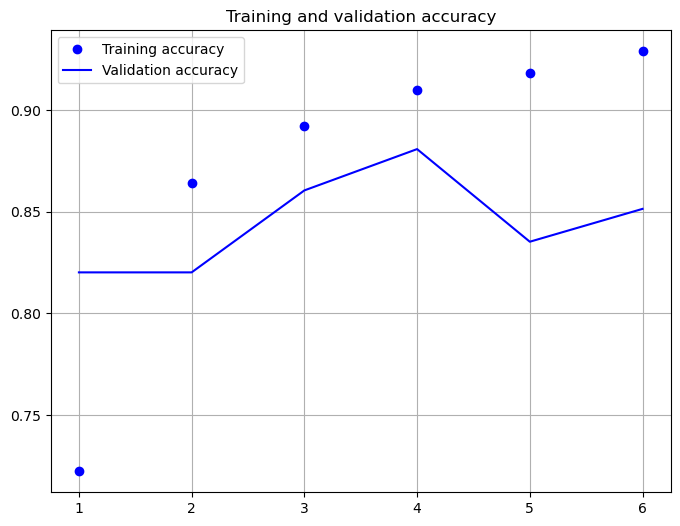

In [85]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
max_val_acc=np.max(val_acc)

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8,6))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [86]:
model.evaluate(X_test,y_test)

782/782 [==============================] - 42s 53ms/step - loss: 0.4811 - categorical_accuracy: 0.8514


[0.48110508918762207, 0.8514000177383423]

As shown above, after 6 epochs of training the cross-entropy-loss is 0.4811 and the accuracy is 85.14%. However, it seems that the accuracy-value after 2 epochs has been higher, than the accuracy after 6 epochs. This indicates overfitting due to too long learning.

## Bidirectional LSTM architecture with Attention

### Define Custom Attention Layer
Since Keras does not provide an attention-layer, we have to implement this type on our own. The implementation below corresponds to the attention-concept as introduced in [Bahdanau et al: Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/pdf/1409.0473.pdf).

The general concept of writing custom Keras layers is described in the corresponding [Keras documentation](https://keras.io/layers/writing-your-own-keras-layers/). 

Any custom layer class inherits from the layer-class and must implement three methods:

- `build(input_shape)`: this is where you will define your weights. This method must set `self.built = True`, which can be done by calling `super([Layer], self).build()`.
- `call(x)`: this is where the layer's logic lives. Unless you want your layer to support masking, you only have to care about the first argument passed to call: the input tensor.
- `compute_output_shape(input_shape)`: in case your layer modifies the shape of its input, you should specify here the shape transformation logic. This allows Keras to do automatic shape inference.

In [90]:
from tensorflow.keras import regularizers, initializers,constraints
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     #name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [91]:
embedding_layer = Embedding(MAX_NB_WORDS,
                            EMBEDDING_DIM,
                            #weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [92]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_gru = Bidirectional(LSTM(64, return_sequences=True))(embedded_sequences)
l_att = Attention(MAX_SEQUENCE_LENGTH)(l_gru)
preds = Dense(2, activation='softmax')(l_att)
model = Model(sequence_input, preds)

In [93]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 500, 100)          1000000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 500, 128)          84480     
 onal)                                                           
                                                                 
 attention_1 (Attention)     (None, 128)               628       
                                                                 
 dense_5 (Dense)             (None, 2)                 258       
                                                                 
Total params: 1085366 (4.14 MB)
Trainable params: 1085366 (4.14 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________

In [94]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['categorical_accuracy'])

In [95]:
history=model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=6, batch_size=128)

Epoch 1/6
196/196 [==============================] - 166s 837ms/step - loss: 0.6922 - categorical_accuracy: 0.5175 - val_loss: 0.6888 - val_categorical_accuracy: 0.5082
Epoch 2/6
196/196 [==============================] - 162s 829ms/step - loss: 0.5559 - categorical_accuracy: 0.7150 - val_loss: 0.3844 - val_categorical_accuracy: 0.8459
Epoch 3/6
196/196 [==============================] - 163s 831ms/step - loss: 0.3490 - categorical_accuracy: 0.8574 - val_loss: 0.3288 - val_categorical_accuracy: 0.8570
Epoch 4/6
196/196 [==============================] - 162s 829ms/step - loss: 0.2747 - categorical_accuracy: 0.8916 - val_loss: 0.3041 - val_categorical_accuracy: 0.8746
Epoch 5/6
196/196 [==============================] - 163s 832ms/step - loss: 0.2300 - categorical_accuracy: 0.9111 - val_loss: 0.2938 - val_categorical_accuracy: 0.8753
Epoch 6/6
196/196 [==============================] - 163s 830ms/step - loss: 0.1996 - categorical_accuracy: 0.9239 - val_loss: 0.2776 - val_categorical_acc

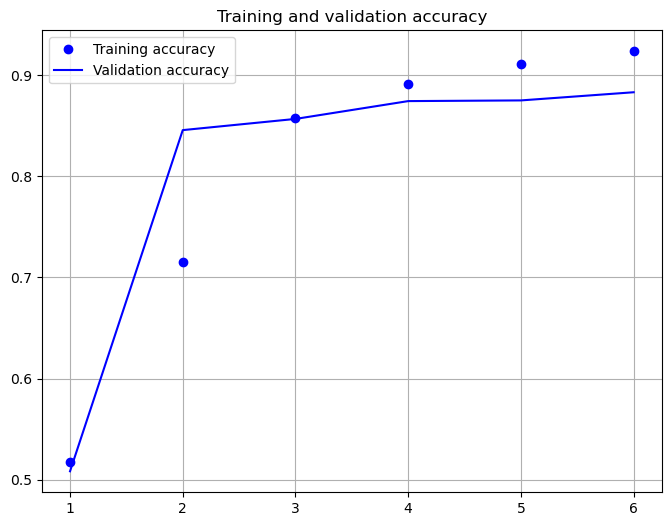

In [96]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
max_val_acc=np.max(val_acc)

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8,6))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [97]:
model.evaluate(X_test,y_test)

782/782 [==============================] - 45s 58ms/step - loss: 0.2776 - categorical_accuracy: 0.8834


[0.27762892842292786, 0.8833600282669067]

Again, the achieved accuracy is in the same range as for the other architectures. None of the architectures has been optimized, e.g. through hyperparameter-tuning. However, the goal of this notebook is not the determination of an optimal model, but the demonstration of how modern neural network architectures can be implemented for text-classification.